## Extra credit assignment

In this homework, you will use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [2]:
## read the data

data = pd.read_csv('https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD', 
                   parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point
0,50124567,MEJU,Queens,528,49TH AVE,11101.0,3474951977,NaN,1900-01-01,NaN,...,NaN,40.743787,-73.955849,402.0,26.0,700.0,4436593.0,4.000320e+09,QN31,NaN
1,50109862,EAGLES CAFE & BAR,Queens,6869,FRESH POND RD,11385.0,3476744578,NaN,1900-01-01,NaN,...,NaN,40.703441,-73.895440,405.0,30.0,58100.0,4088113.0,4.036280e+09,QN20,NaN
2,41558982,GOLDEN EAGLE RESTAURANT,Bronx,97579,MORRIS PARK AVENUE,NaN,7188634028,American,2018-11-29,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,0.000000,0.000000,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN
3,50015841,19 CAFE,Brooklyn,84,MANHATTAN AVENUE,11206.0,7183878777,Coffee/Tea,2022-04-25,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.705232,-73.944593,301.0,34.0,50500.0,3071330.0,3.030790e+09,BK90,NaN
4,50114221,ODAAN,Queens,907,SENECA AVENUE,11385.0,3475752781,NaN,1900-01-01,NaN,...,NaN,40.700625,-73.904006,405.0,34.0,55100.0,4082846.0,4.034660e+09,QN20,NaN


In [3]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA', 'Location Point'],
      dtype='object')

You only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [4]:
## keep only the above columns
data=data[['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']]
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
0,50124567,11101.0,1900-01-01,NaN,NaN,NaN,NaN,40.743787,-73.955849
1,50109862,11385.0,1900-01-01,NaN,NaN,NaN,NaN,40.703441,-73.895440
2,41558982,NaN,2018-11-29,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,12.0,A,0.000000,0.000000
3,50015841,11206.0,2022-04-25,Violations were cited in the following area(s).,Lighting Inadequate,0.0,NaN,40.705232,-73.944593
4,50114221,11385.0,1900-01-01,NaN,NaN,NaN,NaN,40.700625,-73.904006
...,...,...,...,...,...,...,...,...,...
230292,50091430,11417.0,2019-12-11,Violations were cited in the following area(s).,"No facilities available to wash, rinse and san...",40.0,C,40.676509,-73.845871
230293,50003842,10036.0,2019-11-14,Violations were cited in the following area(s).,Cold food item held above 41º F (smoked fish a...,68.0,NaN,40.757244,-73.983815
230294,40399422,11357.0,2021-08-19,Violations were cited in the following area(s).,Food not protected from potential source of co...,9.0,A,40.786929,-73.808329
230295,50074118,10022.0,2022-04-14,Violations were cited in the following area(s).,Food Protection Certificate not held by superv...,10.0,A,40.756918,-73.972066


### Keep data only for 2019

In [5]:
#the data from 2019-1-1 to 2019-12-31
data=data[(data['INSPECTION DATE']>=pd.Timestamp('20190101'))&(data['INSPECTION DATE']<=pd.Timestamp('20191231'))]
data.describe()

,CAMIS,ZIPCODE,SCORE,Latitude,Longitude
count,6.295800e+04,61945.000000,61080.000000,62903.000000,62903.000000
mean,4.637082e+07,10700.139931,20.230665,40.076529,-72.747758
std,4.387904e+06,593.694558,14.670311,5.127729,9.307457
min,3.007544e+07,10001.000000,0.000000,0.000000,-74.248708
25%,4.139572e+07,10023.000000,11.000000,40.690036,-73.987878
50%,5.001412e+07,10474.000000,14.000000,40.734727,-73.953959
75%,5.007021e+07,11231.000000,26.000000,40.763531,-73.890304
max,5.010164e+07,12345.000000,150.000000,40.912822,0.000000


In [6]:
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
5,41689822,10002.0,2019-12-18,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,12.0,A,40.719331,-73.984928
21,50056283,11211.0,2019-12-18,Violations were cited in the following area(s).,MISBRANDED AND LABELING,NaN,NaN,40.710667,-73.958111
29,50038781,NaN,2019-10-09,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,16.0,NaN,0.000000,0.000000
37,40993786,10308.0,2019-03-19,Violations were cited in the following area(s).,Lighting Inadequate,4.0,A,40.553506,-74.143505
47,50003042,10019.0,2019-12-30,No violations were recorded at the time of thi...,NaN,0.0,A,40.763034,-73.976265
...,...,...,...,...,...,...,...,...,...
230282,41004486,10012.0,2019-11-25,Violations were cited in the following area(s).,Live roaches present in facility's food and/or...,17.0,NaN,40.731508,-74.000545
230283,50092304,11004.0,2019-09-17,Violations were cited in the following area(s).,Food not protected from potential source of co...,20.0,NaN,40.746932,-73.712141
230285,41695531,10018.0,2019-11-26,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,10.0,A,40.752317,-73.982145
230292,50091430,11417.0,2019-12-11,Violations were cited in the following area(s).,"No facilities available to wash, rinse and san...",40.0,C,40.676509,-73.845871


### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [7]:
ind1=data[data['ACTION']=='Establishment re-closed by DOHMH']
len(ind1)

0

In [8]:
ind2=data[data['ACTION']=='Establishment re-closed by DOHMH.']
len(ind2)

0

In [9]:
ind=data[(data['ACTION']=='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.')|(data['ACTION']=='Establishment re-closed by DOHMH.')] 
data.drop(index=ind.index,inplace=True)
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
5,41689822,10002.0,2019-12-18,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,12.0,A,40.719331,-73.984928
21,50056283,11211.0,2019-12-18,Violations were cited in the following area(s).,MISBRANDED AND LABELING,NaN,NaN,40.710667,-73.958111
29,50038781,NaN,2019-10-09,Violations were cited in the following area(s).,Hot food item not held at or above 140º F.,16.0,NaN,0.000000,0.000000
37,40993786,10308.0,2019-03-19,Violations were cited in the following area(s).,Lighting Inadequate,4.0,A,40.553506,-74.143505
47,50003042,10019.0,2019-12-30,No violations were recorded at the time of thi...,NaN,0.0,A,40.763034,-73.976265
...,...,...,...,...,...,...,...,...,...
230282,41004486,10012.0,2019-11-25,Violations were cited in the following area(s).,Live roaches present in facility's food and/or...,17.0,NaN,40.731508,-74.000545
230283,50092304,11004.0,2019-09-17,Violations were cited in the following area(s).,Food not protected from potential source of co...,20.0,NaN,40.746932,-73.712141
230285,41695531,10018.0,2019-11-26,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,10.0,A,40.752317,-73.982145
230292,50091430,11417.0,2019-12-11,Violations were cited in the following area(s).,"No facilities available to wash, rinse and san...",40.0,C,40.676509,-73.845871


### You only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [10]:
violCat = pd.read_csv('https://raw.githubusercontent.com/CUSP2020PUI/Data/master/RestViol_types.csv')
violCat.head()

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816
2,"Food contact surface not properly washed, rins...",25889
3,Food not protected from potential source of co...,25336
4,Cold food item held above 41Âº F (smoked fish ...,22834


In [11]:
# keep rows just for above categories
data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
data.shape

(27047, 9)

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [12]:
data.GRADE.unique()

array(['A', 'B', nan, 'C', 'N', 'Z', 'P'], dtype=object)

In [13]:
data.drop(data[data['GRADE'].isin(['P','N','Z'])].index,inplace=True)
data.GRADE.unique()

array(['A', 'B', nan, 'C'], dtype=object)

In [14]:
data

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude
62,50014841,NaN,2019-08-23,Violations were cited in the following area(s).,Food contact surface not properly maintained.,10.0,A,0.000000,0.000000
84,50044955,11375.0,2019-02-04,Violations were cited in the following area(s).,Food contact surface not properly maintained.,27.0,B,40.717287,-73.835120
212,50090182,11236.0,2019-12-23,Violations were cited in the following area(s).,Wiping cloths soiled or not stored in sanitizi...,12.0,A,40.636378,-73.898817
219,50068583,NaN,2019-05-09,Violations were cited in the following area(s).,Evidence of mice or live mice present in facil...,30.0,NaN,0.000000,0.000000
244,50060612,10011.0,2019-11-18,Violations were cited in the following area(s).,Evidence of mice or live mice present in facil...,17.0,NaN,40.742155,-74.000758
...,...,...,...,...,...,...,...,...,...
230275,50013062,10033.0,2019-12-02,Violations were cited in the following area(s).,Food not protected from potential source of co...,12.0,A,40.848532,-73.932469
230282,41004486,10012.0,2019-11-25,Violations were cited in the following area(s).,Live roaches present in facility's food and/or...,17.0,NaN,40.731508,-74.000545
230283,50092304,11004.0,2019-09-17,Violations were cited in the following area(s).,Food not protected from potential source of co...,20.0,NaN,40.746932,-73.712141
230285,41695531,10018.0,2019-11-26,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,10.0,A,40.752317,-73.982145


Zip codes shapefile

In [15]:
#!git clone https://github.com/CUSP2020PUI/Data.git
zips = gpd.read_file("Data/zip_code/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [16]:
# or use this
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [17]:
violation=data.merge(zips,how='left',left_on='ZIPCODE',right_on='ZIPCODE')
violation

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,POPULATION,geometry
0,50014841,NaN,2019-08-23,Violations were cited in the following area(s).,Food contact surface not properly maintained.,10.0,A,0.000000,0.000000,NaN,None
1,50044955,11375.0,2019-02-04,Violations were cited in the following area(s).,Food contact surface not properly maintained.,27.0,B,40.717287,-73.835120,68555.0,"POLYGON ((1024087.848 207717.141, 1024197.644 ..."
2,50090182,11236.0,2019-12-23,Violations were cited in the following area(s).,Wiping cloths soiled or not stored in sanitizi...,12.0,A,40.636378,-73.898817,94480.0,"POLYGON ((1012306.415 178457.610, 1012350.198 ..."
3,50068583,NaN,2019-05-09,Violations were cited in the following area(s).,Evidence of mice or live mice present in facil...,30.0,NaN,0.000000,0.000000,NaN,None
4,50060612,10011.0,2019-11-18,Violations were cited in the following area(s).,Evidence of mice or live mice present in facil...,17.0,NaN,40.742155,-74.000758,50594.0,"POLYGON ((986378.434 210178.599, 986279.129 20..."
...,...,...,...,...,...,...,...,...,...,...,...
27730,50013062,10033.0,2019-12-02,Violations were cited in the following area(s).,Food not protected from potential source of co...,12.0,A,40.848532,-73.932469,54284.0,"POLYGON ((1003020.865 256049.162, 1003096.046 ..."
27731,41004486,10012.0,2019-11-25,Violations were cited in the following area(s).,Live roaches present in facility's food and/or...,17.0,NaN,40.731508,-74.000545,24276.0,"POLYGON ((985200.056 205072.020, 985312.136 20..."
27732,50092304,11004.0,2019-09-17,Violations were cited in the following area(s).,Food not protected from potential source of co...,20.0,NaN,40.746932,-73.712141,11776.0,"POLYGON ((1064411.492 212668.861, 1064437.657 ..."
27733,41695531,10018.0,2019-11-26,Violations were cited in the following area(s).,Facility not vermin proof. Harborage or condit...,10.0,A,40.752317,-73.982145,5503.0,"POLYGON ((983778.602 216668.149, 983835.127 21..."


In [18]:
len(violation.geometry.isna())

27735

In [19]:
len(violation.CAMIS.unique())

9530

### Next, you need to aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [20]:
# get number of violations and average score
df=violation.groupby(by='ZIPCODE')['VIOLATION DESCRIPTION'].count()
df=df.tolist()
df

[416,
 572,
 702,
 588,
 32,
 43,
 111,
 307,
 212,
 420,
 479,
 494,
 456,
 369,
 293,
 298,
 523,
 7,
 135,
 402,
 142,
 266,
 237,
 67,
 199,
 275,
 211,
 24,
 172,
 114,
 164,
 114,
 130,
 477,
 24,
 149,
 18,
 83,
 2,
 3,
 178,
 3,
 98,
 2,
 3,
 3,
 3,
 8,
 2,
 33,
 2,
 142,
 1,
 2,
 5,
 1,
 6,
 1,
 1,
 8,
 2,
 15,
 3,
 11,
 63,
 53,
 36,
 44,
 54,
 64,
 14,
 41,
 52,
 53,
 37,
 124,
 200,
 131,
 117,
 146,
 127,
 67,
 125,
 212,
 63,
 93,
 217,
 178,
 346,
 135,
 67,
 111,
 97,
 131,
 98,
 51,
 56,
 154,
 20,
 35,
 70,
 7,
 14,
 12,
 315,
 86,
 312,
 136,
 142,
 177,
 1,
 324,
 75,
 103,
 178,
 171,
 127,
 146,
 286,
 92,
 411,
 94,
 97,
 197,
 374,
 156,
 274,
 130,
 120,
 517,
 150,
 230,
 165,
 88,
 142,
 176,
 44,
 132,
 58,
 276,
 139,
 56,
 106,
 140,
 122,
 223,
 261,
 20,
 213,
 471,
 255,
 70,
 79,
 177,
 13,
 164,
 60,
 14,
 48,
 58,
 33,
 57,
 378,
 56,
 90,
 1,
 539,
 298,
 124,
 270,
 312,
 83,
 41,
 251,
 21,
 21,
 56,
 42,
 49,
 52,
 88,
 105,
 136,
 84,
 85,
 37,


In [21]:
#get the avergage score
df1=violation.groupby(by='ZIPCODE')['SCORE'].mean()
df1=df1.tolist()
df1

[20.67548076923077,
 21.31523642732049,
 18.405982905982906,
 24.156462585034014,
 21.5,
 19.813953488372093,
 18.945945945945947,
 19.55700325732899,
 20.547169811320753,
 18.548926014319807,
 19.592901878914404,
 21.732793522267208,
 20.27252747252747,
 20.119241192411923,
 20.81569965870307,
 19.661073825503355,
 19.374760994263863,
 14.428571428571429,
 20.037037037037038,
 19.435323383084576,
 16.429577464788732,
 19.695488721804512,
 19.523206751054854,
 30.417910447761194,
 20.512562814070353,
 25.276363636363637,
 18.38388625592417,
 16.291666666666668,
 18.703488372093023,
 19.95614035087719,
 23.317073170731707,
 22.79824561403509,
 20.384615384615383,
 17.658280922431867,
 33.458333333333336,
 20.268456375838927,
 23.0,
 19.80722891566265,
 8.5,
 13.0,
 16.96067415730337,
 25.0,
 18.683673469387756,
 24.0,
 9.666666666666666,
 18.666666666666668,
 13.333333333333334,
 14.375,
 10.5,
 13.757575757575758,
 11.0,
 19.570422535211268,
 13.0,
 10.0,
 8.2,
 10.0,
 10.3333333333333

In [22]:
## get each grade ratio per zip code
rownames = violation.groupby(by='ZIPCODE')['SCORE'].mean().index
#get the ratio of A
Aratio=[]
for i in rownames:
    dataratio=data[data['ZIPCODE']==i]
    a=len(dataratio.GRADE)
    dataA=dataratio[data['GRADE']=='A']
    b=len(dataA.GRADE)
    ratio=b/a
    Aratio.append(ratio)
#get the ratio of B
Bratio=[]
for i in rownames:
    dataratio=data[data['ZIPCODE']==i]
    a=len(dataratio.GRADE)
    dataB=dataratio[data['GRADE']=='B']
    b=len(dataB.GRADE)
    ratio=b/a
    Bratio.append(ratio)


#get the ratio of C
Cratio=[]
for i in rownames:
    dataratio=data[data['ZIPCODE']==i]
    a=len(dataratio.GRADE)
    dataC=dataratio[data['GRADE']=='C']
    b=len(dataC.GRADE)
    ratio=b/a
    Cratio.append(ratio)

In [23]:
## merge number of violations, avg score and grade ratios 
zipRatio=pd.DataFrame(columns=['ZIPCODE', 'number of violations', 'average score', 'A ratio','B ratio','C ratio'])
zipRatio['ZIPCODE']=rownames
zipRatio['number of violations']=df
zipRatio['average score']=df1
zipRatio['A ratio']=Aratio
zipRatio['B ratio']=Bratio
zipRatio['C ratio']=Cratio
zipRatio


,ZIPCODE,number of violations,average score,A ratio,B ratio,C ratio
0,10001.0,416,20.675481,0.442308,0.064904,0.024038
1,10002.0,572,21.315236,0.332168,0.103147,0.008741
2,10003.0,702,18.405983,0.443020,0.075499,0.029915
3,10004.0,588,24.156463,0.387755,0.027211,0.074830
4,10005.0,32,21.500000,0.437500,0.093750,0.062500
...,...,...,...,...,...,...
198,11692.0,7,8.857143,0.857143,0.000000,0.000000
199,11693.0,92,16.086957,0.608696,0.086957,0.000000
200,11694.0,28,17.214286,0.535714,0.000000,0.000000
201,11697.0,7,14.000000,0.571429,0.428571,0.000000


### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [24]:
data311 = pd.read_csv('https://raw.githubusercontent.com/CUSP2020PUI/Data/master/311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


In [25]:
data311.shape

(22388, 4)

### Group these 311 complaints by zip code

In [26]:
group311=data311.groupby(by='Incident Zip').count().rename(columns={'Complaint Type': 'Complaints'})
group311=group311[['Complaints']]
group311

,Complaints
Incident Zip,
0.0,1
83.0,1
10000.0,2
10001.0,331
10002.0,348
...,...
11692.0,19
11693.0,61
11694.0,30


In [27]:
## merge with zips shapefile and normalize 311 complaints by population (per 1000 people)
group311=group311.merge(zips,how='left',left_on='Incident Zip',right_on='ZIPCODE')

In [28]:
group311=group311.drop_duplicates(subset=['ZIPCODE']).dropna(subset=['ZIPCODE'])
group311=group311.iloc[1:,:]

In [29]:
group311

,Complaints,ZIPCODE,POPULATION,geometry
3,331,10001.0,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
4,348,10002.0,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
5,505,10003.0,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
6,75,10004.0,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19..."
10,55,10005.0,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19..."
...,...,...,...,...
219,61,11691.0,60267.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ..."
220,19,11692.0,18018.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ..."
221,61,11693.0,11052.0,"POLYGON ((1030865.641 170727.666, 1030861.340 ..."
225,30,11694.0,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ..."


In [30]:
## merge with the violations features data from above
group311=group311.merge(zipRatio,how='left',left_on='ZIPCODE',right_on='ZIPCODE')
group311

,Complaints,ZIPCODE,POPULATION,geometry,number of violations,average score,A ratio,B ratio,C ratio
0,331,10001.0,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",416.0,20.675481,0.442308,0.064904,0.024038
1,348,10002.0,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",572.0,21.315236,0.332168,0.103147,0.008741
2,505,10003.0,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",702.0,18.405983,0.443020,0.075499,0.029915
3,75,10004.0,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",588.0,24.156463,0.387755,0.027211,0.074830
4,55,10005.0,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",32.0,21.500000,0.437500,0.093750,0.062500
...,...,...,...,...,...,...,...,...,...
205,61,11691.0,60267.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",50.0,23.880000,0.460000,0.060000,0.000000
206,19,11692.0,18018.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",7.0,8.857143,0.857143,0.000000,0.000000
207,61,11693.0,11052.0,"POLYGON ((1030865.641 170727.666, 1030861.340 ...",92.0,16.086957,0.608696,0.086957,0.000000
208,30,11694.0,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",28.0,17.214286,0.535714,0.000000,0.000000


### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [31]:
group311=group311[group311['POPULATION']>0]
group311['norm_Complaints']=(group311['Complaints']/group311['POPULATION'])*1000
group311['norm_violations']=(group311['number of violations']/group311['POPULATION'])*1000
group311

,Complaints,ZIPCODE,POPULATION,geometry,number of violations,average score,A ratio,B ratio,C ratio,norm_Complaints,norm_violations
0,331,10001.0,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",416.0,20.675481,0.442308,0.064904,0.024038,14.768215,18.560657
1,348,10002.0,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",572.0,21.315236,0.332168,0.103147,0.008741,4.280180,7.035238
2,505,10003.0,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",702.0,18.405983,0.443020,0.075499,0.029915,9.037546,12.563084
3,75,10004.0,2187.0,"POLYGON ((981197.409 196571.082, 981485.049 19...",588.0,24.156463,0.387755,0.027211,0.074830,34.293553,268.861454
4,55,10005.0,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",32.0,21.500000,0.437500,0.093750,0.062500,6.784261,3.947206
...,...,...,...,...,...,...,...,...,...,...,...
205,61,11691.0,60267.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",50.0,23.880000,0.460000,0.060000,0.000000,1.012163,0.829641
206,19,11692.0,18018.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",7.0,8.857143,0.857143,0.000000,0.000000,1.054501,0.388500
207,61,11693.0,11052.0,"POLYGON ((1030865.641 170727.666, 1030861.340 ...",92.0,16.086957,0.608696,0.086957,0.000000,5.519363,8.324285
208,30,11694.0,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",28.0,17.214286,0.535714,0.000000,0.000000,1.487874,1.388682


In [32]:
# check statistics of all features
group311.describe()

,Complaints,ZIPCODE,POPULATION,number of violations,average score,A ratio,B ratio,C ratio,norm_Complaints,norm_violations
count,183.000000,183.000000,183.000000,182.000000,182.000000,182.000000,182.000000,182.000000,183.000000,182.000000
mean,121.306011,10816.628415,44646.710383,149.615385,19.336165,0.444118,0.075354,0.028865,13.079935,43.615857
std,99.718474,573.261369,26560.800082,138.025562,3.513195,0.129729,0.061966,0.045268,129.203719,514.238077
min,1.000000,10001.000000,16.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.170940,0.257268
25%,49.500000,10301.500000,25059.500000,52.000000,17.569451,0.371488,0.035417,0.000000,1.408555,1.425149
50%,96.000000,11106.000000,40528.000000,112.500000,19.526580,0.428571,0.065785,0.016021,2.006087,2.368754
75%,157.500000,11360.500000,62613.000000,198.500000,21.278700,0.486996,0.103617,0.038836,3.430040,4.541792
max,505.000000,11697.000000,109069.000000,702.000000,33.458333,1.000000,0.428571,0.297872,1750.000000,6937.500000


In [33]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
group311=group311[group311['norm_Complaints']<30]
group311.dropna(subset=['norm_violations','average score','A ratio','B ratio','C ratio'])
group311

,Complaints,ZIPCODE,POPULATION,geometry,number of violations,average score,A ratio,B ratio,C ratio,norm_Complaints,norm_violations
0,331,10001.0,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",416.0,20.675481,0.442308,0.064904,0.024038,14.768215,18.560657
1,348,10002.0,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",572.0,21.315236,0.332168,0.103147,0.008741,4.280180,7.035238
2,505,10003.0,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",702.0,18.405983,0.443020,0.075499,0.029915,9.037546,12.563084
4,55,10005.0,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",32.0,21.500000,0.437500,0.093750,0.062500,6.784261,3.947206
5,37,10006.0,3011.0,"POLYGON ((981136.343 198082.384, 981481.097 19...",43.0,19.813953,0.465116,0.000000,0.000000,12.288276,14.280970
...,...,...,...,...,...,...,...,...,...,...,...
205,61,11691.0,60267.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",50.0,23.880000,0.460000,0.060000,0.000000,1.012163,0.829641
206,19,11692.0,18018.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",7.0,8.857143,0.857143,0.000000,0.000000,1.054501,0.388500
207,61,11693.0,11052.0,"POLYGON ((1030865.641 170727.666, 1030861.340 ...",92.0,16.086957,0.608696,0.086957,0.000000,5.519363,8.324285
208,30,11694.0,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",28.0,17.214286,0.535714,0.000000,0.000000,1.487874,1.388682


### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

<AxesSubplot:>

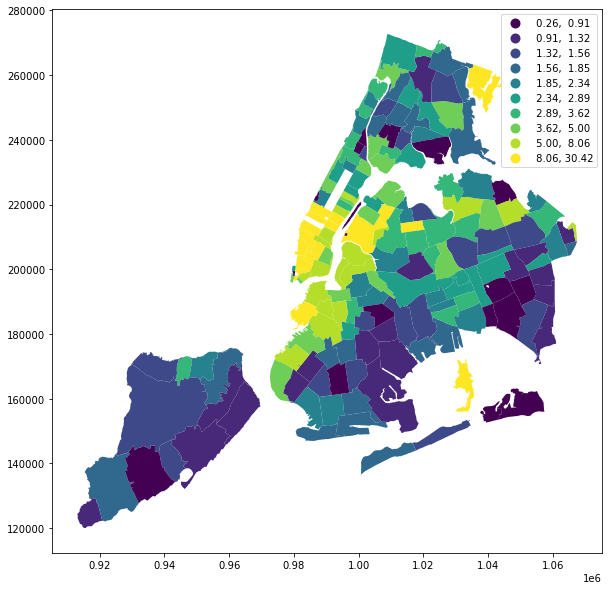

In [34]:
## normalized number of violations (per 1000 people)

group311=gpd.GeoDataFrame(group311)
group311.plot(figsize = (10,10), column='norm_violations', scheme='Quantiles', k=10, legend=True)


<AxesSubplot:>

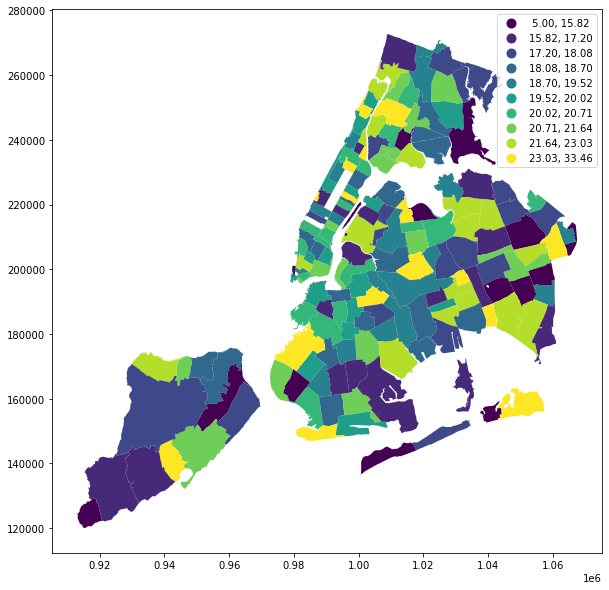

In [35]:
## average score
group311.plot(figsize = (10,10), column='average score', scheme='Quantiles', k=10, legend=True)

<AxesSubplot:>

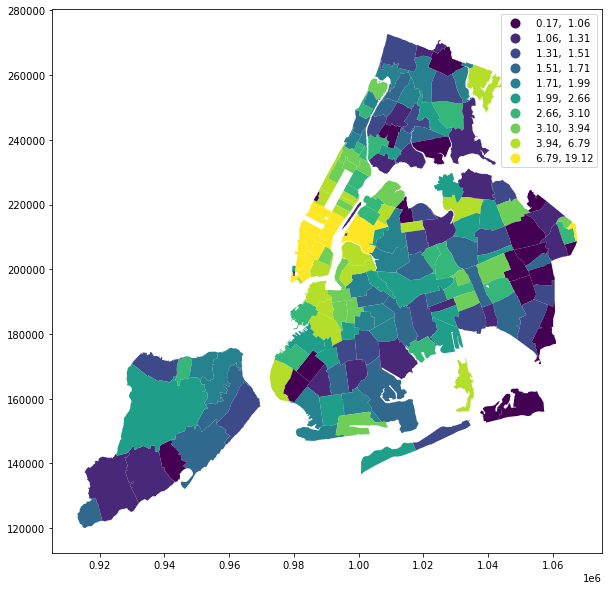

In [36]:
## normalized 311 complaints (per 1000 people)
group311.plot(figsize = (10,10), column='norm_Complaints', scheme='Quantiles', k=10, legend=True)

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [37]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [38]:
#keep the data we want
#Take only the following features: normalized number of violations, average score and ratios for each grade for the task
K_data=['number of violations','average score','A ratio','B ratio','C ratio']
clu_data=group311[K_data]
clu_data=clu_data.dropna()

In [39]:
from sklearn.preprocessing import StandardScaler

#Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(clu_data)

# Transform the data using the scaler
scale_data = scaler.transform(clu_data)

In [40]:
#clu_data=clu_data.dropna()

In [41]:
clu_data 

,number of violations,average score,A ratio,B ratio,C ratio
0,416.0,20.675481,0.442308,0.064904,0.024038
1,572.0,21.315236,0.332168,0.103147,0.008741
2,702.0,18.405983,0.443020,0.075499,0.029915
4,32.0,21.500000,0.437500,0.093750,0.062500
5,43.0,19.813953,0.465116,0.000000,0.000000
...,...,...,...,...,...
205,50.0,23.880000,0.460000,0.060000,0.000000
206,7.0,8.857143,0.857143,0.000000,0.000000
207,92.0,16.086957,0.608696,0.086957,0.000000
208,28.0,17.214286,0.535714,0.000000,0.000000


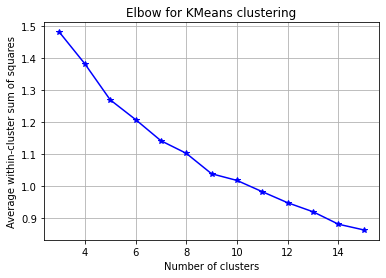

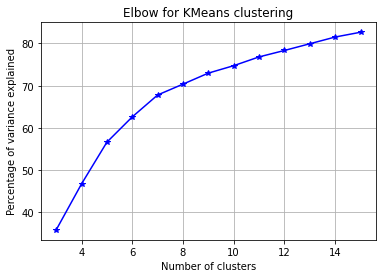

In [42]:
## perform clustring analyses
elbow(scale_data, range(3,16))


In [43]:
## use average silhouette score (just report the scores and choose best for number of clusters to be used)
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15]
for n_clusters in range_n_clusters: #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(scale_data)
    #report average Silhouette score
    silhouette_avg = silhouette_score(scale_data, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))




For n_clusters =3, the average silhouette_score is :0.240783218146494
For n_clusters =4, the average silhouette_score is :0.2646149758956579
For n_clusters =5, the average silhouette_score is :0.27609873189556267
For n_clusters =6, the average silhouette_score is :0.28726613970348136
For n_clusters =7, the average silhouette_score is :0.281793879215712
For n_clusters =8, the average silhouette_score is :0.2460051692499465
For n_clusters =9, the average silhouette_score is :0.24442232410830655
For n_clusters =10, the average silhouette_score is :0.2215692514582767
For n_clusters =11, the average silhouette_score is :0.2585119676246628
For n_clusters =12, the average silhouette_score is :0.22977608016407322
For n_clusters =13, the average silhouette_score is :0.2311714034666957
For n_clusters =14, the average silhouette_score is :0.22201888353768912
For n_clusters =15, the average silhouette_score is :0.2345552782043548


###### For n_clusters =6, the average silhouette_score is :0.28726613970348136
So we choosse 6 as the cluster number

<AxesSubplot:title={'center':'predict_label'}>

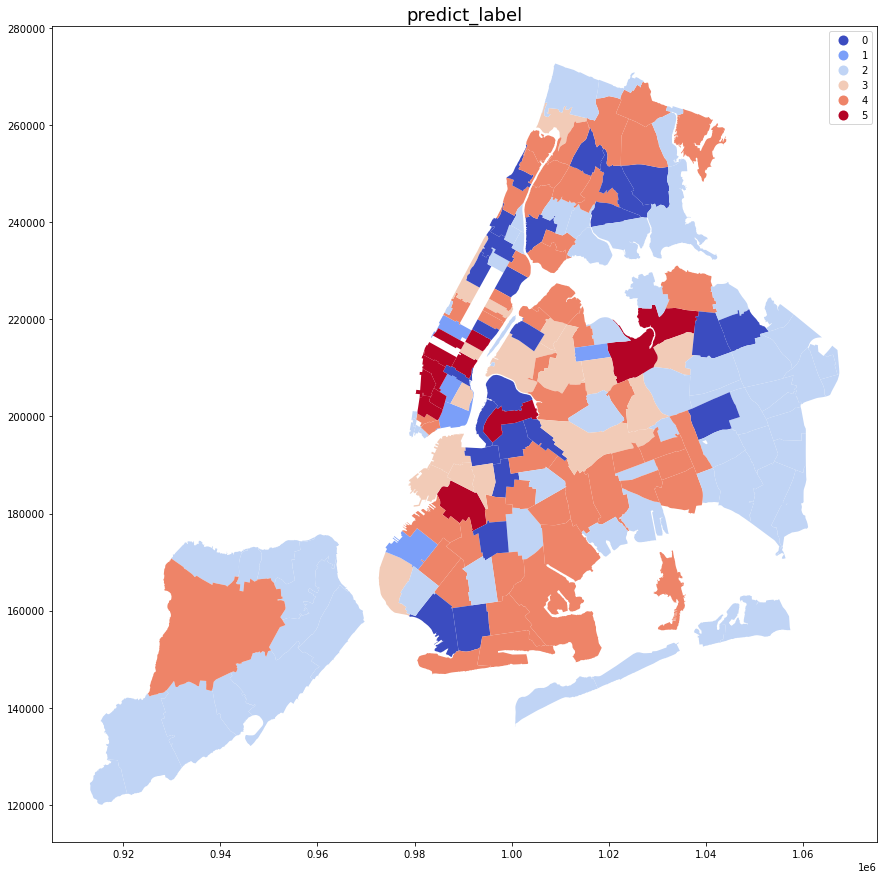

In [44]:
group311=group311.dropna()

km=KMeans(n_clusters=6, random_state=324)
km.labels=km.fit(group311[K_data])
km.labels
group311['label']=km.labels_
group311['label'] =group311['label'].astype(str)
f, ax = plt.subplots(1, figsize=(15, 15))
ax.set_title('predict_label', fontsize=18)
group311.plot(column='label',cmap='coolwarm', legend=True,ax=ax)

In [45]:
## try with (3-15 clusters)

In [46]:
## plot all clustered zips in the map


### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

In [47]:
group311=group311.rename(columns={'A ratio': 'A_ratio','B ratio': 'B_ratio','C ratio': 'C_ratio'})
group311

,Complaints,ZIPCODE,POPULATION,geometry,number of violations,average score,A_ratio,B_ratio,C_ratio,norm_Complaints,norm_violations,label
0,331,10001.0,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",416.0,20.675481,0.442308,0.064904,0.024038,14.768215,18.560657,5
1,348,10002.0,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",572.0,21.315236,0.332168,0.103147,0.008741,4.280180,7.035238,1
2,505,10003.0,55878.0,"POLYGON ((989830.469 207048.126, 989716.354 20...",702.0,18.405983,0.443020,0.075499,0.029915,9.037546,12.563084,1
4,55,10005.0,8107.0,"POLYGON ((982595.679 195880.754, 982587.366 19...",32.0,21.500000,0.437500,0.093750,0.062500,6.784261,3.947206,2
5,37,10006.0,3011.0,"POLYGON ((981136.343 198082.384, 981481.097 19...",43.0,19.813953,0.465116,0.000000,0.000000,12.288276,14.280970,2
...,...,...,...,...,...,...,...,...,...,...,...,...
205,61,11691.0,60267.0,"POLYGON ((1054519.888 162245.759, 1054622.095 ...",50.0,23.880000,0.460000,0.060000,0.000000,1.012163,0.829641,2
206,19,11692.0,18018.0,"POLYGON ((1041797.850 157921.399, 1041802.450 ...",7.0,8.857143,0.857143,0.000000,0.000000,1.054501,0.388500,2
207,61,11693.0,11052.0,"POLYGON ((1030865.641 170727.666, 1030861.340 ...",92.0,16.086957,0.608696,0.086957,0.000000,5.519363,8.324285,4
208,30,11694.0,20163.0,"POLYGON ((1034425.420 153503.826, 1034416.180 ...",28.0,17.214286,0.535714,0.000000,0.000000,1.487874,1.388682,2


In [48]:
lm = smf.ols(formula='norm_Complaints~norm_violations', data = group311).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        norm_Complaints   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     402.4
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.90e-47
Time:                        00:32:49   Log-Likelihood:                -346.60
No. Observations:                 179   AIC:                             697.2
Df Residuals:                     177   BIC:                             703.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8826      0.168     

#####  the regressors of norm_violations is statistically signifiant with respect to p-value<5% criteria

In [49]:
lm = smf.ols(formula='norm_Complaints~A_ratio', data = group311).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        norm_Complaints   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                 0.0001322
Date:                Fri, 16 Dec 2022   Prob (F-statistic):              0.991
Time:                        00:32:49   Log-Likelihood:                -452.73
No. Observations:                 179   AIC:                             909.5
Df Residuals:                     177   BIC:                             915.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0964      0.812      3.813      0.0

#####  the regressors of A-ratio is not statistically signifiant with respect to p-value<5% criteria

In [50]:
lm = smf.ols(formula='norm_Complaints~B_ratio', data = group311).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        norm_Complaints   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.146
Date:                Fri, 16 Dec 2022   Prob (F-statistic):              0.286
Time:                        00:32:49   Log-Likelihood:                -452.15
No. Observations:                 179   AIC:                             908.3
Df Residuals:                     177   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4025      0.359      9.482      0.0

#####  the regressors of B-ration is not statistically signifiant with respect to p-value<5% criteria

In [51]:
lm = smf.ols(formula='norm_Complaints~C_ratio', data = group311).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:        norm_Complaints   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.300
Date:                Fri, 16 Dec 2022   Prob (F-statistic):              0.256
Time:                        00:32:49   Log-Likelihood:                -452.07
No. Observations:                 179   AIC:                             908.1
Df Residuals:                     177   BIC:                             914.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2710      0.270     12.127      0.0

#####  the regressors of C-ration is not statistically signifiant with respect to p-value<5% criteria

In [52]:
group311[['norm_Complaints','norm_violations','A_ratio','B_ratio','C_ratio']].corr()

,norm_Complaints,norm_violations,A_ratio,B_ratio,C_ratio
norm_Complaints,1.000000,0.833366,0.000864,-0.080192,-0.085401
norm_violations,0.833366,1.000000,-0.076540,0.004908,-0.052847
A_ratio,0.000864,-0.076540,1.000000,-0.443171,-0.222678
B_ratio,-0.080192,0.004908,-0.443171,1.000000,0.004950
C_ratio,-0.085401,-0.052847,-0.222678,0.004950,1.000000


What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

##### There is a covariance problem. The correlation shows that there is a correlation between some variables.